In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

sns.set(style="whitegrid")
random.seed(42)


In [2]:
import ast

def safe_eval(x):
    """Safely evaluate a Python literal (like a list) stored as string. Return [] on failure."""
    try:
        return ast.literal_eval(x)
    except:
        return []


In [3]:
def preprocess_text(text: str) -> str:
    """
    Preprocess text consistently:
    - lowercase
    - remove urls, emails, digits
    - remove punctuation
    - normalize whitespace
    """
    text = str(text).lower()
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [4]:
def plot_confusion(cm, labels, title):
    """Plot a confusion matrix (counts) using seaborn heatmap."""
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

In [5]:
def save_model(obj, path):
    """Save model or vectorizer with joblib."""
    joblib.dump(obj, path)
    print(f"Saved -> {path}") 

In [6]:
FILE_PATH = r"C:\Users\Laptop World\Desktop\NLPPROJECT\train_cleaned_with_sentences.csv"

df = pd.read_csv(FILE_PATH)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

Loaded rows: 120000
Columns: ['Class Index', 'Clean_Title', 'Clean_Sentences']


In [7]:
# convert Clean_Sentences to list safely
df['Sentences_List'] = df['Clean_Sentences'].apply(safe_eval)

In [8]:
# build sentence-level rows
rows = []
for _, r in df.iterrows():
    for sent in r['Sentences_List']:
        if isinstance(sent, str):
            sent_clean = preprocess_text(sent)
            if len(sent_clean.split()) >= 2:  # keep at least 2 words
                rows.append({'Sentence': sent_clean, 'Label': r['Class Index']})

data_df = pd.DataFrame(rows)
print("Total usable sentences:", len(data_df))

Total usable sentences: 151130


In [11]:
# Label mapping (for reports)
LABEL_NAMES = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
data_df['LabelName'] = data_df['Label'].map(LABEL_NAMES)

In [13]:
# Cell 5: Train/test split (stratified) — used by all subsequent vectorizer cells
X = data_df['Sentence']
y = data_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train sentences:", len(X_train))
print("Test sentences:", len(X_test))


Train sentences: 120904
Test sentences: 30226


Binary vector shapes: (120904, 398739) (30226, 398739)
[Binary] MultinomialNB -> Train Accuracy: 0.9125 (91.3%) | Test Accuracy: 0.8808 (88.1%)

Classification Report (Binary + NB):
              precision    recall  f1-score   support

       World       0.89      0.87      0.88      6968
      Sports       0.92      0.96      0.94      8256
    Business       0.86      0.82      0.84      7001
    Sci/Tech       0.85      0.87      0.86      8001

    accuracy                           0.88     30226
   macro avg       0.88      0.88      0.88     30226
weighted avg       0.88      0.88      0.88     30226



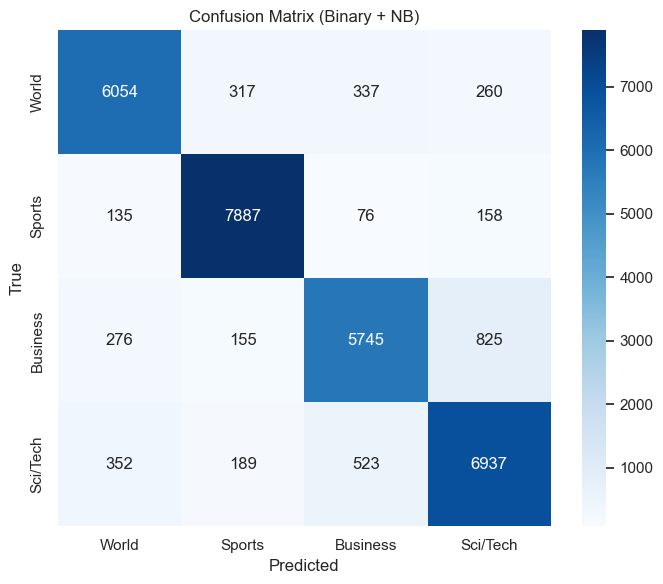

Saved -> nb_binary_model.pkl
Saved -> binary_vectorizer.pkl
[Binary] LogisticRegression Accuracy: 0.8790 (87.9%)
Saved -> lr_binary_model.pkl
[Binary] LinearSVC Accuracy: 0.8676 (86.8%)
Saved -> svc_binary_model.pkl


In [22]:
# Binary Vectorizer cell: binary count features + train NB, LR, SVC and print accuracies
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Vectorizer
binary_vec = CountVectorizer(binary=True, ngram_range=(1,3), min_df=2, max_df=0.95, stop_words='english')
binary_vec.fit(X_train)

# Transform
X_train_bin = binary_vec.transform(X_train)
X_test_bin  = binary_vec.transform(X_test)
print("Binary vector shapes:", X_train_bin.shape, X_test_bin.shape)

# 1) MultinomialNB
nb_bin = MultinomialNB(alpha=1.0)
nb_bin.fit(X_train_bin, y_train)

# --- NB accuracy (train & test) ---
y_pred_bin_test = nb_bin.predict(X_test_bin)
y_pred_bin_train = nb_bin.predict(X_train_bin)
acc_bin_test = accuracy_score(y_test, y_pred_bin_test)
acc_bin_train = accuracy_score(y_train, y_pred_bin_train)
print(f"[Binary] MultinomialNB -> Train Accuracy: {acc_bin_train:.4f} ({acc_bin_train:.1%}) | Test Accuracy: {acc_bin_test:.4f} ({acc_bin_test:.1%})")

print("\nClassification Report (Binary + NB):")
print(classification_report(y_test, y_pred_bin_test, target_names=[LABEL_NAMES[i] for i in sorted(LABEL_NAMES)]))

cm_bin = confusion_matrix(y_test, y_pred_bin_test)
plot_confusion(cm_bin, [LABEL_NAMES[i] for i in sorted(LABEL_NAMES)], title='Confusion Matrix (Binary + NB)')

# Save NB and vectorizer
joblib.dump(nb_bin, "nb_binary_model.pkl")
joblib.dump(binary_vec, "binary_vectorizer.pkl")
print("Saved -> nb_binary_model.pkl")
print("Saved -> binary_vectorizer.pkl")

# 2) LogisticRegression
lr_bin = LogisticRegression(max_iter=2000)
lr_bin.fit(X_train_bin, y_train)
y_pred_lr_bin = lr_bin.predict(X_test_bin)
acc_lr_bin = accuracy_score(y_test, y_pred_lr_bin)
print(f"[Binary] LogisticRegression Accuracy: {acc_lr_bin:.4f} ({acc_lr_bin:.1%})")
joblib.dump(lr_bin, "lr_binary_model.pkl")
print("Saved -> lr_binary_model.pkl")

# 3) LinearSVC
svc_bin = LinearSVC(max_iter=20000)
svc_bin.fit(X_train_bin, y_train)
y_pred_svc_bin = svc_bin.predict(X_test_bin)
acc_svc_bin = accuracy_score(y_test, y_pred_svc_bin)
print(f"[Binary] LinearSVC Accuracy: {acc_svc_bin:.4f} ({acc_svc_bin:.1%})")
joblib.dump(svc_bin, "svc_binary_model.pkl")
print("Saved -> svc_binary_model.pkl")

# store summary
binary_summary = {
    'vectorizer': 'binary',
    'nb_acc': acc_bin_test,
    'nb_train_acc': acc_bin_train,
    'lr_acc': acc_lr_bin,
    'svc_acc': acc_svc_bin
}


Count vector shapes: (120904, 398739) (30226, 398739)
[Count] MultinomialNB -> Train Accuracy: 0.9121 (91.2%) | Test Accuracy: 0.8799 (88.0%)

Classification Report (Count + NB):
              precision    recall  f1-score   support

       World       0.89      0.87      0.88      6968
      Sports       0.92      0.95      0.94      8256
    Business       0.86      0.82      0.84      7001
    Sci/Tech       0.85      0.86      0.86      8001

    accuracy                           0.88     30226
   macro avg       0.88      0.88      0.88     30226
weighted avg       0.88      0.88      0.88     30226



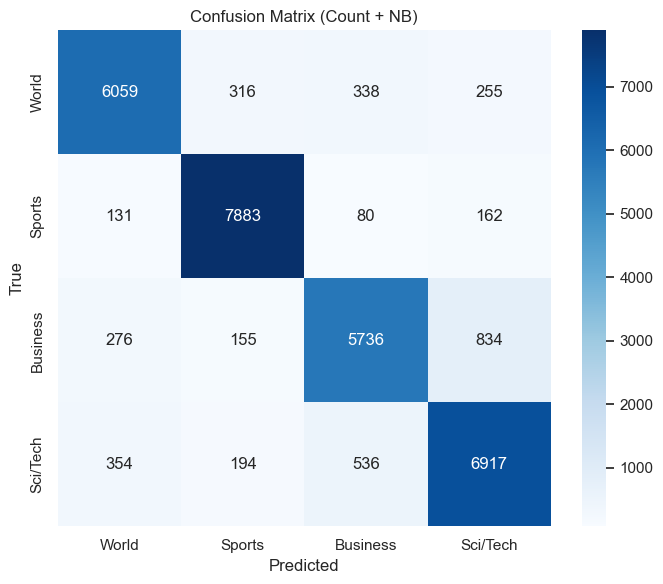

Saved -> nb_count_model.pkl
Saved -> count_vectorizer.pkl
[Count] LogisticRegression Accuracy: 0.8783 (87.8%)
Saved -> lr_count_model.pkl
[Count] LinearSVC Accuracy: 0.8670 (86.7%)
Saved -> svc_count_model.pkl


In [23]:
# Count Vectorizer cell: raw counts + train NB, LR, SVC and print accuracies

count_vec = CountVectorizer(binary=False, ngram_range=(1,3), min_df=2, max_df=0.95, stop_words='english')
count_vec.fit(X_train)

X_train_cnt = count_vec.transform(X_train)
X_test_cnt  = count_vec.transform(X_test)
print("Count vector shapes:", X_train_cnt.shape, X_test_cnt.shape)

# 1) MultinomialNB
nb_cnt = MultinomialNB(alpha=1.0)
nb_cnt.fit(X_train_cnt, y_train)

# NB accuracy
y_pred_cnt_test = nb_cnt.predict(X_test_cnt)
y_pred_cnt_train = nb_cnt.predict(X_train_cnt)
acc_cnt_test = accuracy_score(y_test, y_pred_cnt_test)
acc_cnt_train = accuracy_score(y_train, y_pred_cnt_train)
print(f"[Count] MultinomialNB -> Train Accuracy: {acc_cnt_train:.4f} ({acc_cnt_train:.1%}) | Test Accuracy: {acc_cnt_test:.4f} ({acc_cnt_test:.1%})")

print("\nClassification Report (Count + NB):")
print(classification_report(y_test, y_pred_cnt_test, target_names=[LABEL_NAMES[i] for i in sorted(LABEL_NAMES)]))

cm_cnt = confusion_matrix(y_test, y_pred_cnt_test)
plot_confusion(cm_cnt, [LABEL_NAMES[i] for i in sorted(LABEL_NAMES)], title='Confusion Matrix (Count + NB)')

# Save
joblib.dump(nb_cnt, "nb_count_model.pkl")
joblib.dump(count_vec, "count_vectorizer.pkl")
print("Saved -> nb_count_model.pkl")
print("Saved -> count_vectorizer.pkl")

# LogisticRegression
lr_cnt = LogisticRegression(max_iter=2000)
lr_cnt.fit(X_train_cnt, y_train)
y_pred_lr_cnt = lr_cnt.predict(X_test_cnt)
acc_lr_cnt = accuracy_score(y_test, y_pred_lr_cnt)
print(f"[Count] LogisticRegression Accuracy: {acc_lr_cnt:.4f} ({acc_lr_cnt:.1%})")
joblib.dump(lr_cnt, "lr_count_model.pkl")
print("Saved -> lr_count_model.pkl")

# LinearSVC
svc_cnt = LinearSVC(max_iter=20000)
svc_cnt.fit(X_train_cnt, y_train)
y_pred_svc_cnt = svc_cnt.predict(X_test_cnt)
acc_svc_cnt = accuracy_score(y_test, y_pred_svc_cnt)
print(f"[Count] LinearSVC Accuracy: {acc_svc_cnt:.4f} ({acc_svc_cnt:.1%})")
joblib.dump(svc_cnt, "svc_count_model.pkl")
print("Saved -> svc_count_model.pkl")

count_summary = {
    'vectorizer': 'count',
    'nb_acc': acc_cnt_test,
    'nb_train_acc': acc_cnt_train,
    'lr_acc': acc_lr_cnt,
    'svc_acc': acc_svc_cnt
}


TF-IDF vector shapes: (120904, 398739) (30226, 398739)
[TF-IDF] MultinomialNB -> Train Accuracy: 0.9131 (91.3%) | Test Accuracy: 0.8798 (88.0%)

Classification Report (TF-IDF + NB):
              precision    recall  f1-score   support

       World       0.90      0.86      0.88      6968
      Sports       0.91      0.96      0.94      8256
    Business       0.86      0.81      0.84      7001
    Sci/Tech       0.84      0.87      0.86      8001

    accuracy                           0.88     30226
   macro avg       0.88      0.88      0.88     30226
weighted avg       0.88      0.88      0.88     30226



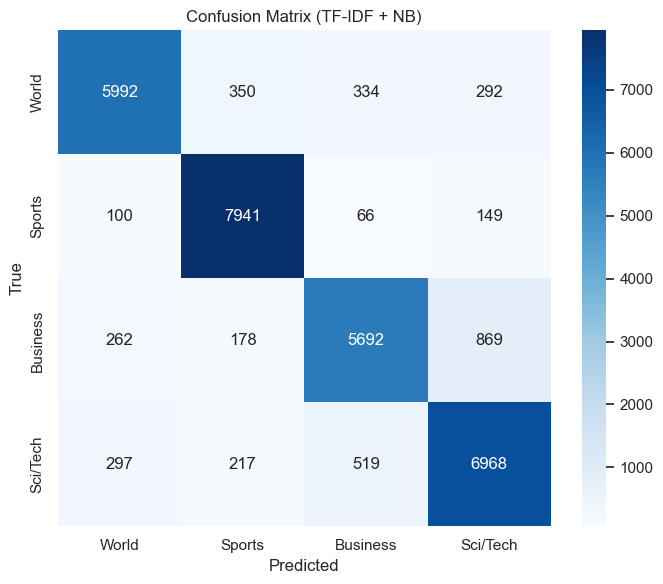

Saved -> nb_tfidf_model.pkl
Saved -> tfidf_vectorizer.pkl
[TF-IDF] LogisticRegression Accuracy: 0.8811 (88.1%)
Saved -> lr_tfidf_model.pkl
[TF-IDF] LinearSVC Accuracy: 0.8878 (88.8%)
Saved -> svc_tfidf_model.pkl


In [24]:
# TF-IDF cell: TF-IDF features + train NB, LR, SVC and print accuracies

tfidf_vec = TfidfVectorizer(ngram_range=(1,3), lowercase=True, stop_words='english', min_df=2, max_df=0.95)
tfidf_vec.fit(X_train)

X_train_tfidf = tfidf_vec.transform(X_train)
X_test_tfidf  = tfidf_vec.transform(X_test)
print("TF-IDF vector shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# 1) MultinomialNB
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

# NB accuracy
y_pred_tfidf_test = nb_tfidf.predict(X_test_tfidf)
y_pred_tfidf_train = nb_tfidf.predict(X_train_tfidf)
acc_tfidf_test = accuracy_score(y_test, y_pred_tfidf_test)
acc_tfidf_train = accuracy_score(y_train, y_pred_tfidf_train)
print(f"[TF-IDF] MultinomialNB -> Train Accuracy: {acc_tfidf_train:.4f} ({acc_tfidf_train:.1%}) | Test Accuracy: {acc_tfidf_test:.4f} ({acc_tfidf_test:.1%})")

print("\nClassification Report (TF-IDF + NB):")
print(classification_report(y_test, y_pred_tfidf_test, target_names=[LABEL_NAMES[i] for i in sorted(LABEL_NAMES)]))

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_test)
plot_confusion(cm_tfidf, [LABEL_NAMES[i] for i in sorted(LABEL_NAMES)], title='Confusion Matrix (TF-IDF + NB)')

# Save NB + vectorizer
joblib.dump(nb_tfidf, "nb_tfidf_model.pkl")
joblib.dump(tfidf_vec, "tfidf_vectorizer.pkl")
print("Saved -> nb_tfidf_model.pkl")
print("Saved -> tfidf_vectorizer.pkl")

# LogisticRegression
lr_tfidf = LogisticRegression(max_iter=2000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
acc_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
print(f"[TF-IDF] LogisticRegression Accuracy: {acc_lr_tfidf:.4f} ({acc_lr_tfidf:.1%})")
joblib.dump(lr_tfidf, "lr_tfidf_model.pkl")
print("Saved -> lr_tfidf_model.pkl")

# LinearSVC
svc_tfidf = LinearSVC(max_iter=20000)
svc_tfidf.fit(X_train_tfidf, y_train)
y_pred_svc_tfidf = svc_tfidf.predict(X_test_tfidf)
acc_svc_tfidf = accuracy_score(y_test, y_pred_svc_tfidf)
print(f"[TF-IDF] LinearSVC Accuracy: {acc_svc_tfidf:.4f} ({acc_svc_tfidf:.1%})")
joblib.dump(svc_tfidf, "svc_tfidf_model.pkl")
print("Saved -> svc_tfidf_model.pkl")

tfidf_summary = {
    'vectorizer': 'tfidf',
    'nb_acc': acc_tfidf_test,
    'nb_train_acc': acc_tfidf_train,
    'lr_acc': acc_lr_tfidf,
    'svc_acc': acc_svc_tfidf
}


In [20]:
# Summary cell: collect summaries and display best options
summary_list = [binary_summary, count_summary, tfidf_summary]
summary_df = pd.DataFrame(summary_list)

# best classifier and accuracy per vectorizer
summary_df['best_classifier'] = summary_df[['nb_acc','lr_acc','svc_acc']].idxmax(axis=1)
summary_df['best_accuracy'] = summary_df[['nb_acc','lr_acc','svc_acc']].max(axis=1)

print("Comparison summary (sorted by best_accuracy):")
display(summary_df.sort_values('best_accuracy', ascending=False).reset_index(drop=True))



Comparison summary (sorted by best_accuracy):


,vectorizer,nb_acc,nb_train_acc,lr_acc,svc_acc,best_classifier,best_accuracy
0,tfidf,0.879805,0.913096,0.881096,0.887812,svc_acc,0.887812
1,binary,0.880798,0.912509,0.879045,0.867597,nb_acc,0.880798
2,count,0.879872,0.912137,0.878251,0.867002,nb_acc,0.879872


Loaded external test: 7600
Using best combination -> Vectorizer: tfidf, Classifier: svc_acc
External test accuracy: 0.9007 (90.1%)

Classification Report (external test):
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.94      0.97      0.95      1900
    Business       0.87      0.85      0.86      1900
    Sci/Tech       0.87      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



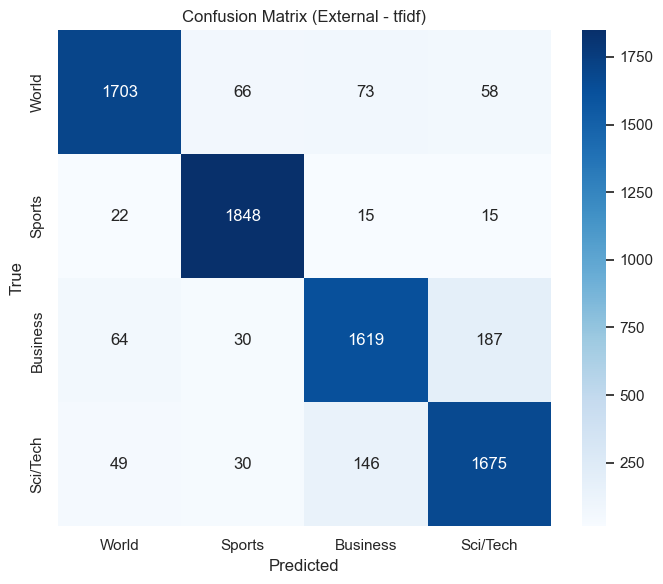

In [27]:
# Cell 10: Evaluate on external test.csv using the best vectorizer + classifier

TEST_PATH = r"C:\Users\Laptop World\Desktop\NLPPROJECT\test.csv"

try:
    test_df = pd.read_csv(TEST_PATH)
    print("Loaded external test:", len(test_df))
    
    # Preprocess the descriptions same as training
    test_df['cleaned'] = test_df['Description'].apply(preprocess_text)
    X_ext = test_df['cleaned']
    y_ext = test_df['Class Index']
    
    # Get best row from summary_df
    best_row = summary_df.loc[summary_df['best_accuracy'].idxmax()]
    best_vec_name = best_row['vectorizer']
    best_clf_key = best_row['best_classifier']  # 'nb_acc', 'lr_acc', 'svc_acc'
    
    print(f"Using best combination -> Vectorizer: {best_vec_name}, Classifier: {best_clf_key}")

    # Vectorizer and model mapping
    vec_map = {
        'binary': 'binary_vectorizer.pkl',
        'count': 'count_vectorizer.pkl',
        'tfidf': 'tfidf_vectorizer.pkl'
    }
    model_map = {
        ('binary','nb_acc'): 'nb_binary_model.pkl',
        ('binary','lr_acc'): 'lr_binary_model.pkl',
        ('binary','svc_acc'): 'svc_binary_model.pkl',
        ('count','nb_acc'): 'nb_count_model.pkl',
        ('count','lr_acc'): 'lr_count_model.pkl',
        ('count','svc_acc'): 'svc_count_model.pkl',
        ('tfidf','nb_acc'): 'nb_tfidf_model.pkl',
        ('tfidf','lr_acc'): 'lr_tfidf_model.pkl',
        ('tfidf','svc_acc'): 'svc_tfidf_model.pkl'
    }
    
    # Load vectorizer and model
    vec = joblib.load(vec_map[best_vec_name])
    model = joblib.load(model_map[(best_vec_name, best_clf_key)])
    
    # Transform and predict
    X_ext_vec = vec.transform(X_ext)
    y_ext_pred = model.predict(X_ext_vec)
    
    # Accuracy
    ext_acc = accuracy_score(y_ext, y_ext_pred)
    print(f"External test accuracy: {ext_acc:.4f} ({ext_acc:.1%})\n")
    
    # Classification report
    print("Classification Report (external test):")
    print(classification_report(
        y_ext, y_ext_pred,
        target_names=[LABEL_NAMES[i] for i in sorted(LABEL_NAMES)]
    ))
    
    # Confusion matrix
    cm_ext = confusion_matrix(y_ext, y_ext_pred)
    plot_confusion(cm_ext, [LABEL_NAMES[i] for i in sorted(LABEL_NAMES)],
                   title=f'Confusion Matrix (External - {best_vec_name})')

except Exception as e:
    print("External test evaluation skipped or failed:", e)
